[INFO] 使用设备: cuda
共找到 72 个 .mat 文件
目标速度 120 m/s，多普勒频移 960.00 Hz


读取数据: 100%|██████████| 72/72 [00:04<00:00, 17.77it/s]


[INFO] 处理后样本数: 215136, 每样本长度: 288

[搜索 1/50] 参数: {'model_dim': 256, 'num_heads': 2, 'num_layers': 1, 'dropout': 0.5, 'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'num_epochs': 200, 'patience': 5}
训练集准确率: 26.93%
验证集准确率: 26.81%
测试集准确率: 26.80%
[INFO] 新最佳模型已保存: search_results\2025-08-20_18-17-55_LTE-V_cross_random_eq_SNR10_fd960.00\best_model.pth

[搜索 2/50] 参数: {'model_dim': 256, 'num_heads': 8, 'num_layers': 1, 'dropout': 0.5, 'batch_size': 128, 'learning_rate': 1e-05, 'weight_decay': 0.0001, 'num_epochs': 200, 'patience': 5}
训练集准确率: 23.96%
验证集准确率: 23.95%
测试集准确率: 23.45%

[搜索 3/50] 参数: {'model_dim': 64, 'num_heads': 8, 'num_layers': 1, 'dropout': 0.5, 'batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'num_epochs': 200, 'patience': 5}
训练集准确率: 27.55%
验证集准确率: 27.50%
测试集准确率: 27.32%
[INFO] 新最佳模型已保存: search_results\2025-08-20_18-17-55_LTE-V_cross_random_eq_SNR10_fd960.00\best_model.pth

[搜索 4/50] 参数: {'model_dim': 64, 'num_heads': 2, 'num_layers': 2, 'dropo

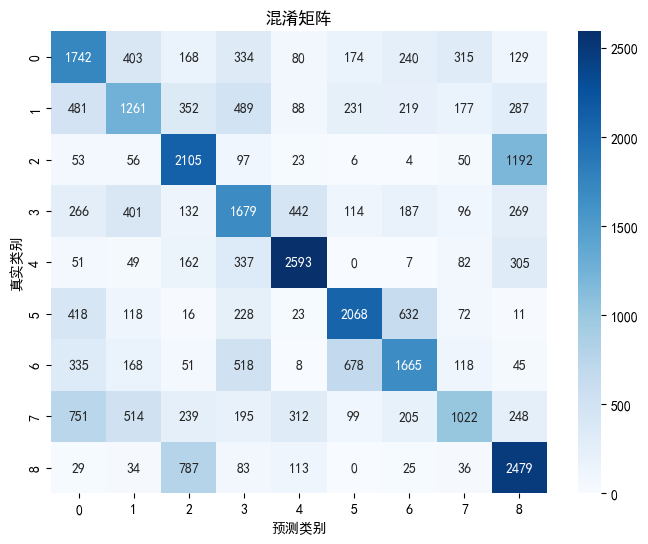


[INFO] 所有结果已保存到: search_results\2025-08-20_18-17-55_LTE-V_cross_random_eq_SNR10_fd960.00\2025-08-20_18-17-55_LTE-V_cross_random_eq_SNR10_fd960.00.txt
[INFO] 最佳混淆矩阵已保存到: search_results\2025-08-20_18-17-55_LTE-V_cross_random_eq_SNR10_fd960.00\best_confusion_matrix.png

[最佳参数] {'model_dim': 64, 'num_heads': 8, 'num_layers': 2, 'dropout': 0.1, 'batch_size': 64, 'learning_rate': 0.001, 'weight_decay': 0.0005, 'num_epochs': 200, 'patience': 5}
[训练集最佳准确率] 52.53%
[验证集最佳准确率] 52.26%
[对应测试集准确率] 51.48%


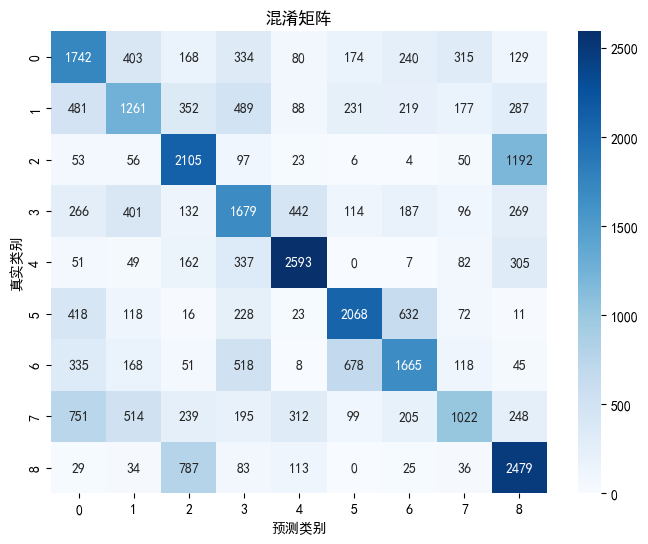

In [ ]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import h5py
import random

# ========== 多普勒 & AWGN ==========
def compute_doppler_shift(v, fc):
    c = 3e8
    v = v/3.6 # 转换为m/s
    return (v / c) * fc

def apply_doppler_shift(signal, fd, fs):
    t = np.arange(signal.shape[-1]) / fs
    doppler_phase = np.exp(1j * 2 * np.pi * fd * t)
    return signal * doppler_phase

def add_awgn(signal, snr_db):
    signal_power = np.mean(np.abs(signal)**2)
    noise_power = signal_power / (10**(snr_db/10))
    noise = np.sqrt(noise_power/2) * (np.random.randn(*signal.shape) + 1j*np.random.randn(*signal.shape))
    return signal + noise

# ========== 数据加载 & 分组 ==========
def load_and_preprocess_with_grouping(mat_folder, group_size=288, apply_doppler=False,
                                      target_velocity=120, apply_awgn=False, snr_db=20,
                                      fs=5e6, fc=5.9e9):
    mat_files = glob.glob(os.path.join(mat_folder, '*.mat'))
    print(f"共找到 {len(mat_files)} 个 .mat 文件")

    fd = compute_doppler_shift(target_velocity, fc)
    print(f"目标速度 {target_velocity} m/s，多普勒频移 {fd:.2f} Hz")

    X_files, y_files, label_set = [], [], set()

    for file in tqdm(mat_files, desc='读取数据'):
        with h5py.File(file, 'r') as f:
            rfDataset = f['rfDataset']
            dmrs_struct = rfDataset['dmrs'][:]
            dmrs_complex = dmrs_struct['real'] + 1j * dmrs_struct['imag']

            txID_uint16 = rfDataset['txID'][:].flatten()
            tx_id = ''.join(chr(c) for c in txID_uint16 if c != 0)

            processed_signals = []
            for i in range(dmrs_complex.shape[0]):
                sig = dmrs_complex[i, :]
                if apply_doppler:
                    sig = apply_doppler_shift(sig, fd, fs)
                if apply_awgn:
                    sig = add_awgn(sig, snr_db)
                iq = np.stack((sig.real, sig.imag), axis=-1)
                processed_signals.append(iq)

            X_files.append(np.array(processed_signals))
            y_files.append(tx_id)
            label_set.add(tx_id)

    label_list = sorted(list(label_set))
    label_to_idx = {label: i for i, label in enumerate(label_list)}

    X_all_list, y_all_list = [], []

    for label in label_list:
        files_idx = [i for i, y in enumerate(y_files) if y == label]
        num_files = len(files_idx)
        if num_files == 0:
            continue

        samples_per_file = group_size // num_files
        if samples_per_file == 0:
            continue

        min_samples = min([X_files[i].shape[0] for i in files_idx])
        max_groups = min_samples // samples_per_file
        if max_groups == 0:
            continue

        for group_i in range(max_groups):
            pieces = []
            for fi in files_idx:
                start = group_i * samples_per_file
                end = start + samples_per_file
                piece = X_files[fi][start:end]
                pieces.append(piece)

            big_block = np.concatenate(pieces, axis=0)
            big_block_t = np.transpose(big_block, (1, 0, 2))
            X_all_list.append(big_block_t)
            y_all_list.append(np.full(group_size, label_to_idx[label], dtype=np.int64))

    X_all = np.concatenate(X_all_list, axis=0)
    y_all = np.concatenate(y_all_list, axis=0)
    print(f"[INFO] 处理后样本数: {X_all.shape[0]}, 每样本长度: {X_all.shape[1]}")

    return X_all, y_all, label_to_idx

# ========== 模型 ==========
class SignalTransformer(nn.Module):
    def __init__(self, raw_input_dim, model_dim, num_heads, num_layers, num_classes, dropout=0.4):
        super(SignalTransformer, self).__init__()
        self.embedding = nn.Linear(raw_input_dim, model_dim)
        encoder_layer = TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = x[:, -1, :]
        return self.fc(x)

# ========== 评估 ==========
def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    acc = 100 * correct / total
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return acc, cm

# ========== 混淆矩阵可视化 ==========
def plot_confusion_matrix(cm, save_path=None):
    plt.figure(figsize=(8,6))
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('混淆矩阵')
    plt.ylabel('真实类别')
    plt.xlabel('预测类别')
    if save_path:
        plt.savefig(save_path)
    plt.show()

# ========== 单次训练（增加训练集准确率） ==========
def train_and_validate(params, X_train, y_train, X_val, y_val, label_to_idx, device):
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.long)),
                               batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(y_val, dtype=torch.long)),
                             batch_size=params['batch_size'], shuffle=False)

    model = SignalTransformer(2, params['model_dim'], params['num_heads'],
                              params['num_layers'], len(label_to_idx), params['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_acc = 0
    best_train_acc = 0
    patience_counter = 0
    best_model_wts = None

    for epoch in range(params['num_epochs']):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # 训练集和验证集准确率
        train_acc, _ = evaluate_model(model, train_loader, device, len(label_to_idx))
        val_acc, _ = evaluate_model(model, val_loader, device, len(label_to_idx))

        # print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc = train_acc
            best_model_wts = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= params['patience']:
                break

    model.load_state_dict(best_model_wts)
    return best_train_acc, best_val_acc, model

# ========== 主流程（随机搜索） ==========
def main():
    # 固定随机种子
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] 使用设备: {device}")

    # ======= 配置保存路径 =======
    SNR_dB = 10
    fd = compute_doppler_shift(120, 2.4e9)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    script_name = "LTE-V_cross_random_eq"
    folder_name = f"{timestamp}_{script_name}_SNR{SNR_dB}_fd{fd:.2f}"
    save_dir = os.path.join("search_results", folder_name)
    os.makedirs(save_dir, exist_ok=True)
    results_file = os.path.join(save_dir, f"{folder_name}.txt")

    data_path = "E:/rf_datasets/"
    X_all, y_all, label_to_idx = load_and_preprocess_with_grouping(
        data_path, group_size=288, apply_doppler=False, target_velocity=120,
        apply_awgn=False, snr_db=SNR_dB, fs=5e6, fc=5.9e9
    )

    X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_all, test_size=0.3, stratify=y_all, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    param_grid = {
        'model_dim': [64, 128, 256],
        'num_heads': [2, 4, 8],
        'num_layers': [1, 2],
        'dropout': [0.1, 0.3, 0.5],
        'batch_size': [64, 128, 256],
        'learning_rate': [1e-5, 1e-4, 5e-4, 1e-3],
        'weight_decay': [1e-4, 5e-4],
        'num_epochs': [200],
        'patience': [5]
    }

    all_combinations = [
        {k: random.choice(v) for k, v in param_grid.items()}
        for _ in range(50)
    ]

    best_params = None
    best_val_acc = 0
    best_train_acc = 0
    best_model = None
    best_test_acc = 0
    best_test_cm = None
    results = []

    for i, params in enumerate(all_combinations, 1):
        print(f"\n[搜索 {i}/{len(all_combinations)}] 参数: {params}")
        train_acc, val_acc, model = train_and_validate(params, X_train, y_train, X_val, y_val, label_to_idx, device)
        print(f"训练集准确率: {train_acc:.2f}%")
        print(f"验证集准确率: {val_acc:.2f}%")

        test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                               torch.tensor(y_test, dtype=torch.long)),
                                 batch_size=params['batch_size'], shuffle=False)
        test_acc, test_cm = evaluate_model(model, test_loader, device, len(label_to_idx))
        print(f"测试集准确率: {test_acc:.2f}%")

        results.append({
            "params": params,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "test_acc": test_acc
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc = train_acc
            best_params = params
            best_model = model
            best_test_acc = test_acc
            best_test_cm = test_cm

            # <<< 新增：保存最佳模型
            best_model_path = os.path.join(save_dir, "best_model.pth")
            torch.save(best_model.state_dict(), best_model_path)
            print(f"[INFO] 新最佳模型已保存: {best_model_path}")

    # ===== 保存结果到 txt 文件 =====
    with open(results_file, "w", encoding="utf-8") as f:
        f.write(f"数据集名称: {data_path}\n")
        f.write("===== 随机搜索结果 =====\n")
        for idx, r in enumerate(results, 1):
            f.write(f"[组合 {idx}] 参数: {r['params']} | Train Acc: {r['train_acc']:.2f}% "
                    f"| Val Acc: {r['val_acc']:.2f}% | Test Acc: {r['test_acc']:.2f}%\n")
        f.write("\n===== 最佳结果 =====\n")
        f.write(f"最佳参数: {best_params}\n")
        f.write(f"训练集准确率: {best_train_acc:.2f}%\n")
        f.write(f"验证集准确率: {best_val_acc:.2f}%\n")
        f.write(f"测试集准确率: {best_test_acc:.2f}%\n")

    # ===== 保存最佳混淆矩阵 =====
    cm_path = os.path.join(save_dir, "best_confusion_matrix.png")
    plot_confusion_matrix(best_test_cm, save_path=cm_path)

    print(f"\n[INFO] 所有结果已保存到: {results_file}")
    print(f"[INFO] 最佳混淆矩阵已保存到: {cm_path}")

    print(f"\n[最佳参数] {best_params}")
    print(f"[训练集最佳准确率] {best_train_acc:.2f}%")
    print(f"[验证集最佳准确率] {best_val_acc:.2f}%")
    print(f"[对应测试集准确率] {best_test_acc:.2f}%")
    plot_confusion_matrix(best_test_cm)


if __name__ == "__main__":
    main()
